In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt


In [2]:
# Dataset class that generates 4 two-dimensional Gaussians and includes DataLoader creation
class GaussianDataset(Dataset):
    def __init__(self, n_per_class=500, means=None, covariances=None, seed=None, train_split=0.9):
        if seed is not None:
            np.random.seed(seed)
        # Default means and covariances (4 well-separated clusters)
        if means is None:
            means = [np.array([-5, -5]), np.array([5, -5]),
                     np.array([-5, 5]), np.array([5, 5])]
        if covariances is None:
            covariances = [np.eye(2)] * 4

        data_list = []
        labels_list = []
        for class_idx, (mean, cov) in enumerate(zip(means, covariances)):
            samples = np.random.multivariate_normal(mean, cov, n_per_class)
            data_list.append(samples)
            labels_list.append(np.full(n_per_class, class_idx))
        data = np.vstack(data_list)
        labels = np.hstack(labels_list)

        # Randomly permute the dataset
        permutation = np.random.permutation(len(labels))
        self.data = torch.tensor(data[permutation], dtype=torch.float32)
        self.labels = torch.tensor(labels[permutation], dtype=torch.long)
        self.train_split = train_split
        self._split_dataset()

    def _split_dataset(self):
        N = len(self.labels)
        train_size = int(self.train_split * N)
        indices = np.arange(N)
        self.train_indices = indices[:train_size]
        self.test_indices = indices[train_size:]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def get_loaders(self, batch_size=32, shuffle=True):
        train_dataset = Subset(self, self.train_indices)
        test_dataset  = Subset(self, self.test_indices)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
        test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        return train_loader, test_loader

    def plot(self, title="Gaussian Dataset", cmap='viridis', s=10):
        plt.figure(figsize=(8,6))
        scatter = plt.scatter(self.data[:,0], self.data[:,1], c=self.labels, cmap=cmap, s=s)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(title)
        plt.colorbar(scatter, label="Class Label")
        plt.show()




In [3]:
# Fully-connected network for classification using NLLLoss
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4),         # 4 classes
            nn.LogSoftmax(dim=1)      # Log probabilities for NLLLoss
        )
        
    def forward(self, x):
        return self.fc_layers(x)


In [4]:
def compute_accuracy(loader, model):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100 * correct / total

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_loss_list = []   # average train loss per epoch
    test_loss_list = []    # average test loss per epoch
    batch_loss_list = []   # train loss per mini-batch
    train_acc_list = []    # train accuracy per epoch
    test_acc_list = []     # test accuracy per epoch
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            batch_loss_list.append(loss.item())
        avg_train_loss = running_loss / len(train_loader.dataset)
        train_loss_list.append(avg_train_loss)
        
        # Evaluate on test dataset
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
        avg_test_loss = running_test_loss / len(test_loader.dataset)
        test_loss_list.append(avg_test_loss)
        
        # Accuracy calculations
        train_acc = compute_accuracy(train_loader, model)
        test_acc = compute_accuracy(test_loader, model)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        if epoch%5==0:
            print(f"Epoch {epoch+1:02d}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}, " +
              f"Train Acc = {train_acc:.2f}%, Test Acc = {test_acc:.2f}%")
        
    return {
        "train_loss_list": train_loss_list,
        "test_loss_list": test_loss_list,
        "batch_loss_list": batch_loss_list,
        "train_acc_list": train_acc_list,
        "test_acc_list": test_acc_list,
    }

In [5]:
def plot_loss_curves(batch_loss_list, test_loss_list, train_loader, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(batch_loss_list, label="Train Loss per Mini-batch")
    epoch_indices = [i * len(train_loader) for i in range(1, num_epochs+1)]
    plt.plot(epoch_indices, test_loss_list, 'o-', label="Test Loss per Epoch")
    plt.xlabel("Mini-batch Iterations")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()
    plt.show()

def plot_model_predictions(dataset, model):
    model.eval()
    with torch.no_grad():
        inputs = dataset.data  # All data points
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(inputs[:, 0], inputs[:, 1], c=preds, cmap='viridis', s=20)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Model Predictions on Gaussian Dataset")
    plt.colorbar(scatter, label="Predicted Class")
    plt.show()

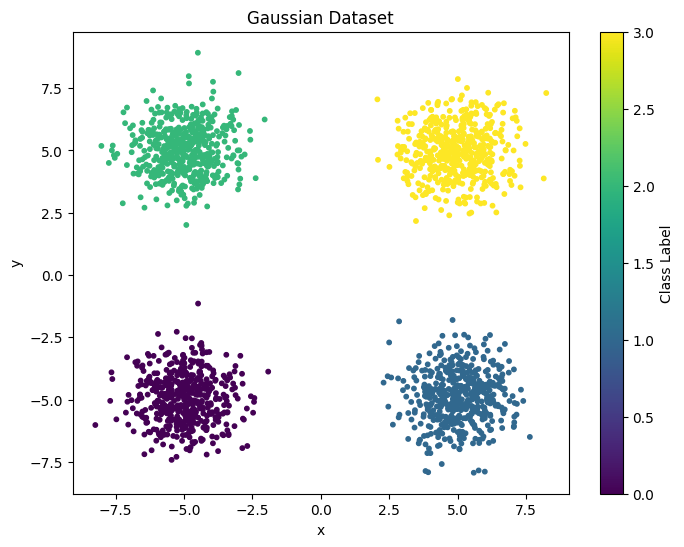

In [6]:
dataset = GaussianDataset(n_per_class=500, seed=42)
train_loader, test_loader = dataset.get_loaders(batch_size=32, shuffle=True)
dataset.plot()

In [7]:
model = Net()
num_epochs=50
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
metrics = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Epoch 01: Train Loss = 0.2511, Test Loss = 0.0117, Train Acc = 100.00%, Test Acc = 100.00%
Epoch 06: Train Loss = 0.0009, Test Loss = 0.0006, Train Acc = 100.00%, Test Acc = 100.00%
Epoch 11: Train Loss = 0.0003, Test Loss = 0.0002, Train Acc = 100.00%, Test Acc = 100.00%
Epoch 16: Train Loss = 0.0001, Test Loss = 0.0001, Train Acc = 100.00%, Test Acc = 100.00%
Epoch 21: Train Loss = 0.0001, Test Loss = 0.0000, Train Acc = 100.00%, Test Acc = 100.00%
Epoch 26: Train Loss = 0.0001, Test Loss = 0.0000, Train Acc = 100.00%, Test Acc = 100.00%
Epoch 31: Train Loss = 0.0000, Test Loss = 0.0000, Train Acc = 100.00%, Test Acc = 100.00%
Epoch 36: Train Loss = 0.0000, Test Loss = 0.0000, Train Acc = 100.00%, Test Acc = 100.00%
Epoch 41: Train Loss = 0.0000, Test Loss = 0.0000, Train Acc = 100.00%, Test Acc = 100.00%
Epoch 46: Train Loss = 0.0000, Test Loss = 0.0000, Train Acc = 100.00%, Test Acc = 100.00%


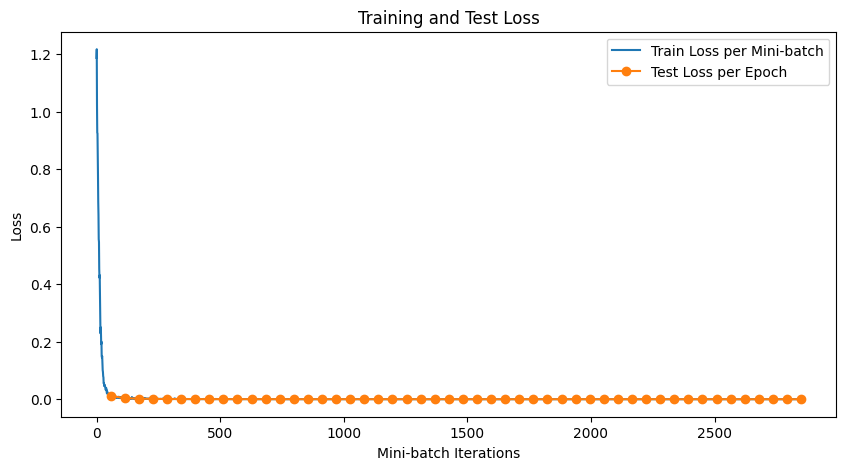

In [8]:
plot_loss_curves(metrics["batch_loss_list"], metrics["test_loss_list"], train_loader, num_epochs)

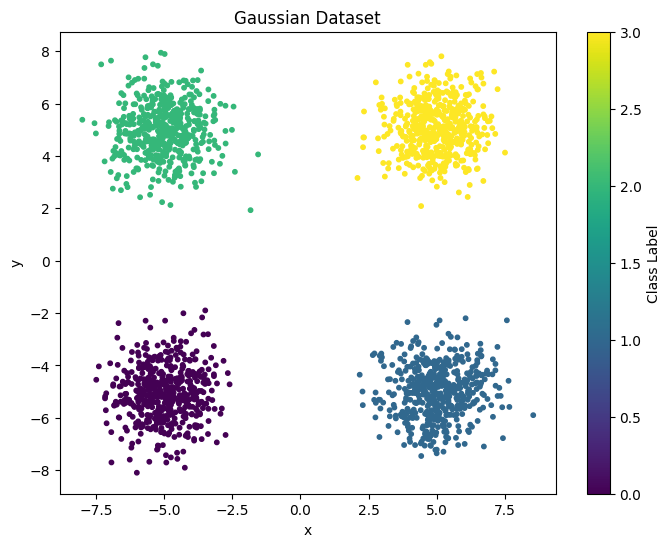

In [9]:
dataset = GaussianDataset(n_per_class=500, seed=45)
dataset.plot()

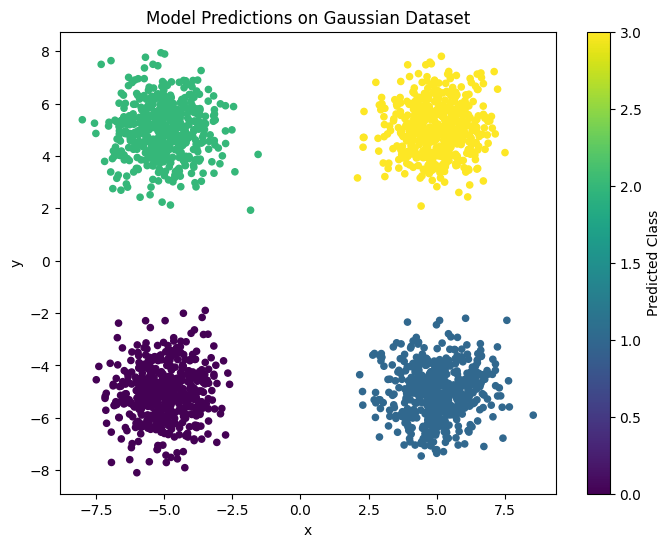

In [10]:
plot_model_predictions(dataset, model)

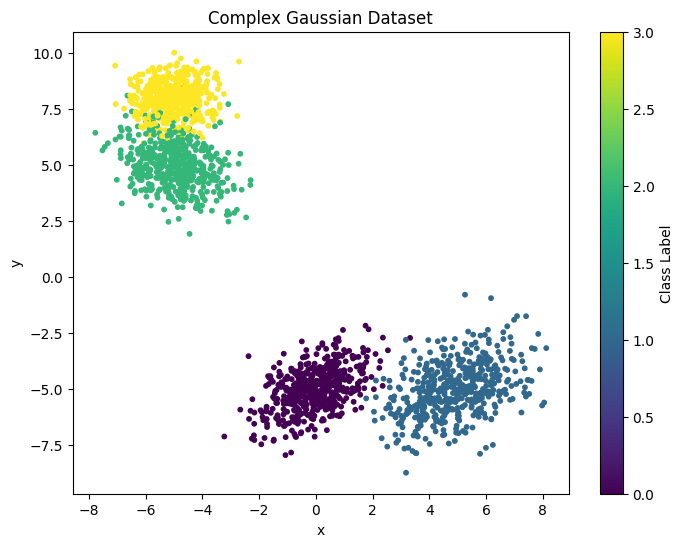

In [11]:

dataset = GaussianDataset(
    n_per_class=500, 
    seed=42,
    means=[
        np.array([0, -5]),
        np.array([5, -5]),
        np.array([-5, 5]),
        np.array([-5, 8]),
        
    ],
    covariances=[
        np.array([[1.0, 0.5], [0.5, 1.0]]),
        np.array([[1.5, 0.7], [0.7, 1.5]]),
        np.array([[1.0, -0.3], [-0.3, 1.0]]),
        np.array([[0.5, 0.0], [0.0, 0.5]]),
    ]
)
train_loader, test_loader = dataset.get_loaders(batch_size=32, shuffle=True)
dataset.plot(title="Complex Gaussian Dataset")

In [12]:
model = Net()
num_epochs=50
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
metrics = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Epoch 01: Train Loss = 0.5651, Test Loss = 0.2353, Train Acc = 92.44%, Test Acc = 93.50%
Epoch 06: Train Loss = 0.1575, Test Loss = 0.1118, Train Acc = 94.11%, Test Acc = 96.00%
Epoch 11: Train Loss = 0.1126, Test Loss = 0.0985, Train Acc = 94.94%, Test Acc = 97.00%
Epoch 16: Train Loss = 0.0874, Test Loss = 0.0757, Train Acc = 97.06%, Test Acc = 96.50%
Epoch 21: Train Loss = 0.0759, Test Loss = 0.0693, Train Acc = 97.61%, Test Acc = 96.50%
Epoch 26: Train Loss = 0.0744, Test Loss = 0.0618, Train Acc = 97.56%, Test Acc = 97.00%
Epoch 31: Train Loss = 0.0701, Test Loss = 0.0670, Train Acc = 97.56%, Test Acc = 96.50%
Epoch 36: Train Loss = 0.0662, Test Loss = 0.0626, Train Acc = 97.61%, Test Acc = 97.00%
Epoch 41: Train Loss = 0.0676, Test Loss = 0.0670, Train Acc = 97.78%, Test Acc = 96.50%
Epoch 46: Train Loss = 0.0657, Test Loss = 0.0624, Train Acc = 97.56%, Test Acc = 97.00%


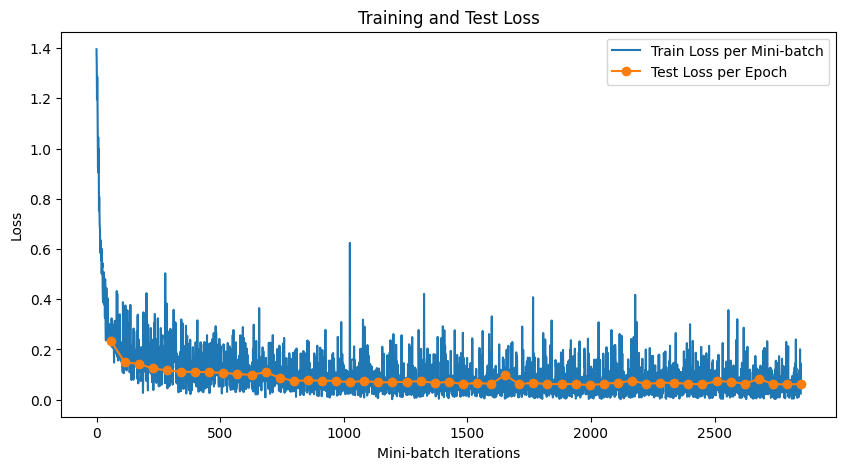

In [13]:
plot_loss_curves(metrics["batch_loss_list"], metrics["test_loss_list"], train_loader, num_epochs)

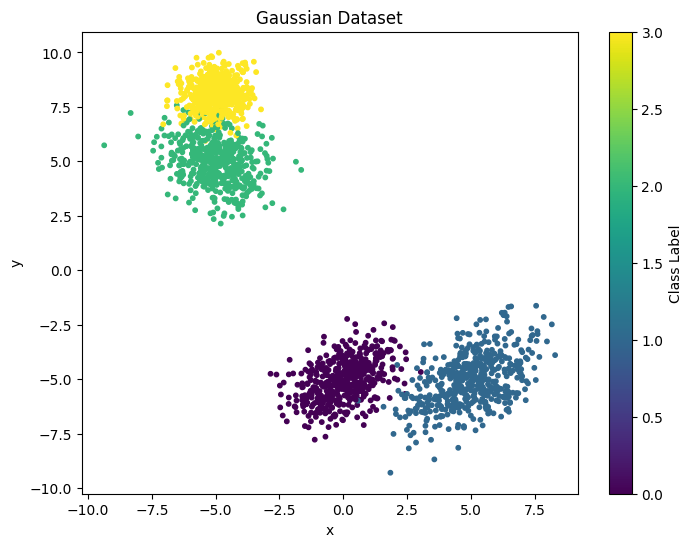

In [14]:
dataset = GaussianDataset(
    n_per_class=500, 
    seed=45,
    means=[
        np.array([0, -5]),
        np.array([5, -5]),
        np.array([-5, 5]),
        np.array([-5, 8]),
        
    ],
    covariances=[
        np.array([[1.0, 0.5], [0.5, 1.0]]),
        np.array([[1.5, 0.7], [0.7, 1.5]]),
        np.array([[1.0, -0.3], [-0.3, 1.0]]),
        np.array([[0.5, 0.0], [0.0, 0.5]]),
    ]
)

dataset.plot()

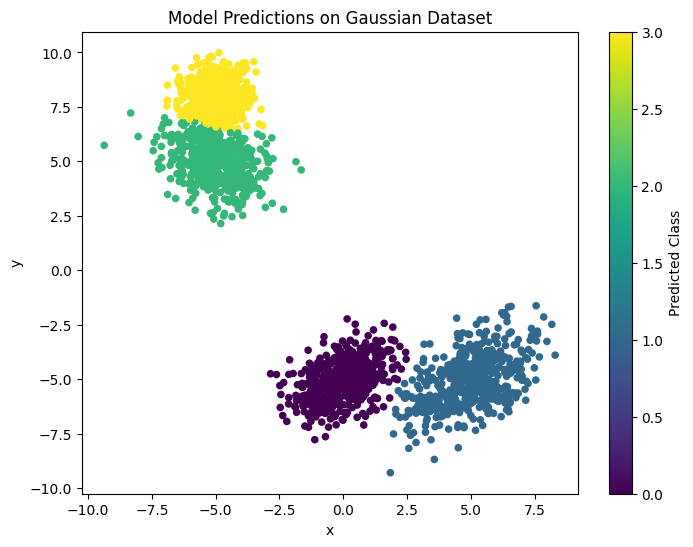

In [15]:
plot_model_predictions(dataset, model)